In [1]:
%load_ext autoreload
%autoreload 2

# Experimenting with ``slfractals``

Some initialisations:

In [2]:
import slfractals as slf
from matplotlib import pyplot as plt
from multiprocessing import Pool
from time import time

xlim = (-2, 1.)
ylim = (-0.9, 0.9)

## Generating a grid

In [3]:
C1 = slf.get_grid(xlim, ylim, resw=10)
# display(C1)
C2 = slf.get_grid(xlim, ylim, resw=10, ratio="28:16")
# display(C2)
C = slf.get_grid(xlim, ylim, resw=500)

## Computing

In [4]:
comp = slf.Compute(slf.mandel, max_value=2, max_iter=300)

All at once:

In [5]:
start = time()
grad, _ = comp(C.flatten())
grad1 = grad.reshape(C.shape)
print("Elapsed time: {}s".format(time() - start))

Elapsed time: 0.6162185668945312s


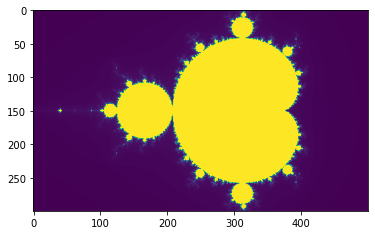

In [6]:
%matplotlib inline
plt.imshow(grad1)

Split and join, serially:

In [7]:
start = time()
spl = slf.split(C.flatten(), nportions=4)
grads, comps2 = zip(*map(comp, spl))
grad2 = slf.join_shape(grads, *C.shape)
print("Elapsed time: {}s".format(time() - start))

Elapsed time: 0.6110365390777588s


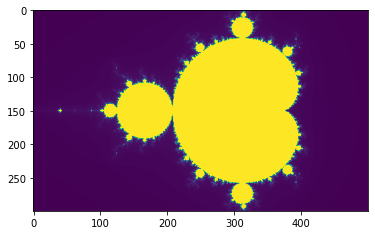

In [8]:
%matplotlib inline
plt.imshow(grad2)

Split and join, with ``Pool``:

In [9]:
start = time()
with Pool(2) as p:
    res = p.map(comp, slf.split(C.flatten(), nportions=4))
grads, comps3 = zip(*res)
grad3 = slf.join_shape(grads, *C.shape)
print("Elapsed time: {}s".format(time() - start))

Elapsed time: 0.3430314064025879s


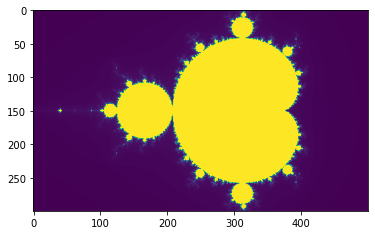

In [10]:
%matplotlib inline
plt.imshow(grad3)

Generating a new compute object for every batch:

In [11]:
start = time()
with Pool(2) as p:
    res = p.map(slf.Compute(slf.mandel, max_value=5, max_iter=300), slf.split(C.flatten(), nportions=4))
grads, comps4 = zip(*res)
grad4 = slf.join_shape(grads, *C.shape)
print("Elapsed time: {}s".format(time() - start))

Elapsed time: 0.39247918128967285s


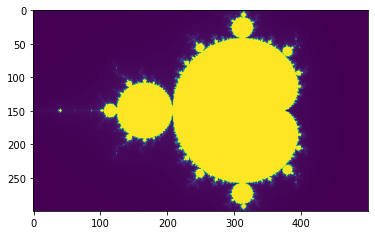

In [12]:
%matplotlib inline
plt.imshow(grad4)

* To compute in parallel pool, the compute object is pickled and thus copied to each separate thread, resulting in a different memory id compared to the original (``comp3``)
* If we create a new compute object directly in ``Pool.map``, then of course we have another id from the beginning. (``comp4``)

In [13]:
print("Original:  {}".format(id(comp)))
print("comps2  : {}".format(list(map(id, comps2))))
print("comps3  : {}".format(list(map(id, comps3))))
print("comps4  : {}".format(list(map(id, comps4))))

Original:  139743076398512
comps2  : [139743076398512, 139743076398512, 139743076398512, 139743076398512]
comps3  : [139741846445168, 139741846443104, 139741846445216, 139741846443152]
comps4  : [139741846454816, 139741846454720, 139741846454768, 139741846458080]


Functions to compute serially or in parallel:

In [14]:
start = time()
grad_serial = slf.serial_compute(
    slf.mandel,
    C,
    max_iter=300,
    max_value=5,
    colorexp=2
)
print("Serial time: {}s".format(time() - start))

Serial time: 0.6344871520996094s


In [15]:
start = time()
grad_parallel = slf.parallel_compute(
    slf.mandel,
    C,
    max_iter=300,
    max_value=5,
    colorexp=2,
    nproc=2
)
print("Parallel time: {}s".format(time() - start))

Parallel time: 0.3697528839111328s


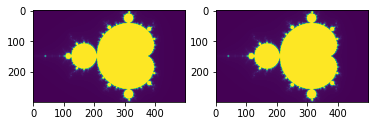

In [16]:
%matplotlib inline
ax1 = plt.subplot(121)
ax1.imshow(grad_serial)
ax2 = plt.subplot(122)
ax2.imshow(grad_parallel)

## Plotting with Bokeh

In [17]:
from bokeh.io import show, output_notebook, push_notebook
from bokeh.plotting import  figure
from bokeh.models import ColumnDataSource
from bokeh.palettes import inferno

output_notebook()

Loading BokehJS ...

In [18]:
from slfractals.colors import ColorGradient
cg = ColorGradient(["#000000", "#ff0000", "00ff00"])
p = figure(
    title="fractal",
    plot_width=grad_parallel.shape[1],
    plot_height=grad_parallel.shape[0],
    x_range=xlim,
    y_range=ylim
)
cds = ColumnDataSource(data={"image": [0.1*grad_parallel]})
img = p.image(image="image", source=cds, x=xlim[0], y=ylim[0], dw=xlim[1]-xlim[0], dh=ylim[1]-ylim[0], palette=cg(100))
nh = show(p, notebook_handle=True)

In [19]:
p = figure(
    title="fractal",
    plot_width=grad_parallel.shape[1],
    plot_height=grad_parallel.shape[0],
    x_range=xlim,
    y_range=ylim
)
cds = ColumnDataSource(
    data={
        "image": [grad_parallel],
        "x": [xlim[0]],
        "y": [ylim[0]],
        "dw": [xlim[1]-xlim[0]],
        "dh": [ylim[1]-ylim[0]]
    }
)
img = p.image(image="image", source=cds, x="x", y="y", dw="dw", dh="dh", palette=inferno(100))
show(p)

In [20]:
push_notebook(handle=nh)

In [21]:
cds.data["image"] = [0.0*grad_parallel]
cds.data = {"image": [0.0*grad_parallel]}

In [22]:
p.plot_width

500

In [23]:
from bokeh.palettes import Blues256, inferno
C.shape

(300, 500)